# CONTEXTO
Nesse assignment, nosso objetivo central é prever e desenvolver uma análise de um problema envolvendo a predição de doenças coronárias (do coração) utilizando um dataset público. Você deve realizar diversas etapas de análise, tanto de código quanto de explicação escrita do motivo pelo qual está fazendo aquilo para enriquecer seu Projeto. Lembrando que, ao longo do desenvolvimento do projeto, você deve responder algumas perguntas do assignment.

# O PROJETO
Pesquisadores coletaram diversas informações sobre pacientes que deram entradas em hospitais de Cleveland, EUA. Afirmando estarem com dores no peito. Dentre as diversas informações coletadas, é fornecido a você um dataset com 14 colunas (13
características e 1 variável alvo) sobre 303 pacientes Você foi convocado pelo hospital da regional para desenvolver um sistema inteligente que, ao fornecer estes atributos, seu modelo mostra se o paciente tem ou não doenças coronárias.
Dependendo do resultado do seu modelo, o paciente é encaminhado mais rapidamente para um especialista. Você deve então criar um modelo de Machine Learning com hiperparâmetros otimizados para o F1 Score (Uma métrica para
problemas de classificação). Lembrando que ao longo da sua análise, introdução, EDA, transformações e modelagem, é importante ressaltar a ideia por trás da sua ação. Fazendo isso, enriquece ainda mais seu projeto e garante um entendimento melhor do leitor.

#INFORMAÇÕES DO DATASET:
- age: Idade (Anos)
- sex: Sexo (1 = Masc e 0 = Fem)
- cp: Nível de dor ( 1 a 4 )
- trestbps: Pressão sanguínea em Repouso
- chol: colesterol em mg/dl:
- fbs: Fasting Blood Sugar (Teste diabético) > 120 mg/dl
- restecg: Eletrocardiogramas em repouso (0,1 ou 2)
- thalach: Ritmo cardíaco
- exang: Exercício físico que gerou Angina
- oldpeak: Depressão de ST induzida por exercício em relação ao
repouso
- slope: Tipo de inclinação do segmento ST de pico do exercício
- ca: número de vasos sanguínios ressaltados (coloridos por
fluoroscopia)
- thal: Talassemia -> 3 = normal; 6 = fixed defect; 7 = reversable
defect




#1. BLIBIOTECAS

In [1]:
from pathlib import Path
import progressbar as pb # Visualizar barra de progresso, bom para operações de longa duração
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings # supress warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from sklearn.metrics.pairwise import cosine_similarity
# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

sns.set(rc={'figure.figsize':(11.7,8.27)}) # isso é pras figuras ficarem maiores

#2. Importando o dados e criando o dataset

In [2]:
%env KAGGLE_USERNAME = tomasmenegatto
%env KAGGLE_KEY = 11458e6485cef3e20517783268b9afac

!content/heart-disease-uci
!kaggle datasets download -d ronitf/heart-disease-uci --unzip -p content/heart-disease-uci
!ls content/heart-disease-uci

DATA_PATH = Path("content/heart-disease-uci")

env: KAGGLE_USERNAME=tomasmenegatto
env: KAGGLE_KEY=11458e6485cef3e20517783268b9afac
/bin/bash: content/heart-disease-uci: No such file or directory
  0% 0.00/3.40k [00:00<?, ?B/s]
100% 3.40k/3.40k [00:00<00:00, 6.26MB/s]
heart.csv


In [3]:
df_original = pd.read_csv(DATA_PATH / 'heart.csv')
df_original.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.300,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.500,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.400,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.800,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.600,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.400,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.300,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.000,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.500,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.600,2,0,2,1


#3. EDA (Análise Exploratória dos Dados)

In [4]:
df = df_original.copy()
df.describe()

# As colunas Trestbps, chol, thalach possuem desvio padrão muito alto
# Médias próximas das medianas

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000
mean,54.366,0.683,0.967,131.624,246.264,0.149,0.528,149.647,0.327,1.040,1.399,0.729,2.314,0.545
std,9.082,0.466,1.032,17.538,51.831,0.356,0.526,22.905,0.470,1.161,0.616,1.023,0.612,0.499
min,29.000,0.000,0.000,94.000,126.000,0.000,0.000,71.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,47.500,0.000,0.000,120.000,211.000,0.000,0.000,133.500,0.000,0.000,1.000,0.000,2.000,0.000
50%,55.000,1.000,1.000,130.000,240.000,0.000,1.000,153.000,0.000,0.800,1.000,0.000,2.000,1.000
75%,61.000,1.000,2.000,140.000,274.500,0.000,1.000,166.000,1.000,1.600,2.000,1.000,3.000,1.000
max,77.000,1.000,3.000,200.000,564.000,1.000,2.000,202.000,1.000,6.200,2.000,4.000,3.000,1.000


In [5]:
df.info()

# Não há valores nulo no dataset
# Apenas uma variável não é inteira
# Nenhuma coluna declarada como categórica

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
df.shape

(303, 14)

##3.1. Coluna Age
Traz a idade dos pacientes em anos

###3.1.1. Histograma

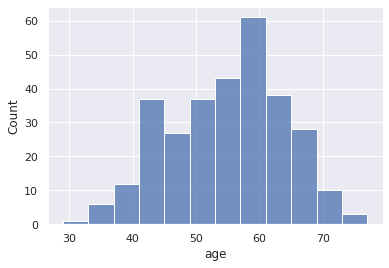

In [7]:
sns.histplot(x='age', data=df)

# Dados relativamente bem distruídos, média de idade elevada.

###3.1.2. Boxplot

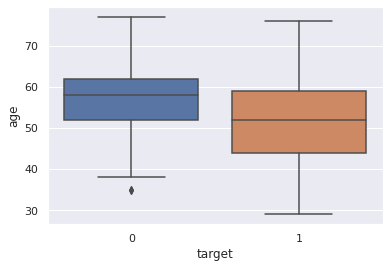

In [8]:
sns.boxplot(x='target', y='age', data=df)

###3.1.3. Frequência das idades

In [9]:
df['age'].value_counts()

# A maioria dos pacientes possuem entre 50 e 60 anos.

58    19
57    17
54    16
59    14
52    13
      ..
37     2
77     1
76     1
74     1
29     1
Name: age, Length: 41, dtype: int64

##3.2. Coluna Sex
Sexo (1 = Masc e 0 = Fem)

In [10]:
df['sex'].value_counts()

# Aproximadamente 66% dos pacientes são homens

1    207
0     96
Name: sex, dtype: int64

##3.3. Coluna Cp
Nível de dor ( 1 a 4 )

In [11]:
df['cp'].value_counts()

# Na descrição da varíavel o nível da dor deveria variar entre 1 a 4, entretanto está variando entre 0 e 3
# 50% dos dados são de pacientes que estavam com um nível baixo de dor

0    143
2     87
1     50
3     23
Name: cp, dtype: int64

##3.4. Coluna Trestbps
Pressão sanguínea em Repouso

###3.4.1. Histograma

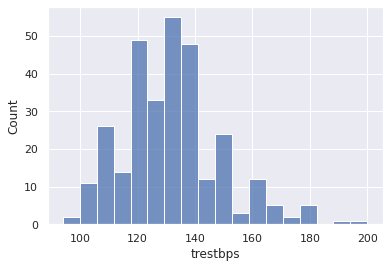

In [12]:
sns.histplot(x='trestbps', data=df)

# Presença de outliers, dados não estão muito bem distribuídos

###3.4.2. Boxplot

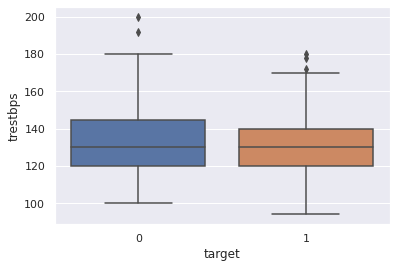

In [13]:
sns.boxplot(x='target', y='trestbps', data=df)

# Possui outliers tanto para caso possitivo quanto negativo

In [14]:
df['trestbps'].value_counts()

# Pressão sanguíneas mais comuns são de 120, 130 e 140

120    37
130    36
140    32
110    19
150    17
       ..
155     1
117     1
154     1
123     1
200     1
Name: trestbps, Length: 49, dtype: int64

##3.5. Coluna Chol
Colesterol em mg/dl

###3.5.1. Histograma

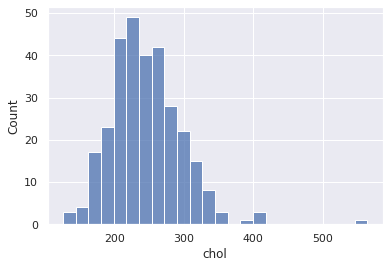

In [15]:
sns.histplot(x='chol', data=df)

# Presença de outliers
# Se eliminarmos os dados maiores que 350, os dados são bem distribuídos

###3.5.2. Boxplot

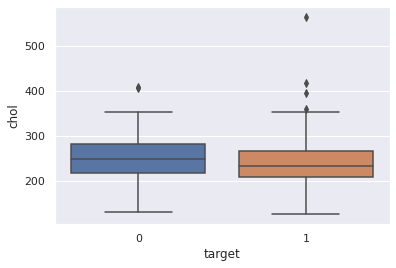

In [16]:
sns.boxplot(x='target', y='chol', data=df)

# Possui alguns outliers para casos negativos e muito outliers para casos positivos, pode ser uma problema para o modelo.


##3.6. Coluna fbs
Fasting Blood Sugar (Teste diabético) > 120 mg/dl

In [17]:
df['fbs'].value_counts()

# Apenas 15% dos pacientes do banco de dados são diabéticos.


0    258
1     45
Name: fbs, dtype: int64

##3.7. Coluna restecg
Eletrocardiogramas em repouso (0,1 ou 2)

In [18]:
df['restecg'].value_counts()

# Apenas 4 pacientes (1% do dataset) possuiam 2 eletrocardiogramas em repouso
# O número de pacientes com 1 eletrocariograma é próximo do número de pacientes com nenhum eletrocariograma

1    152
0    147
2      4
Name: restecg, dtype: int64

##3.8. Coluna thalach
Ritmo cardíaco

###3.8.1. Histograma

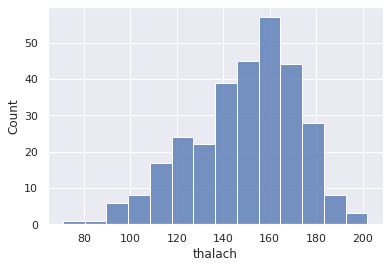

In [19]:
sns.histplot(x='thalach', data=df)

# Possível presença de outliers
# Dados são estão muito bem distribuídos


###3.8.2. Boxplot

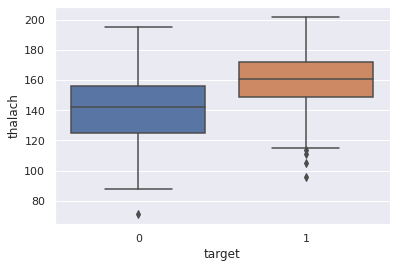

In [20]:
sns.boxplot(x='target', y='thalach', data=df)

# Casos positivos aparentam ter thalach mais alto. Pode ajudar no modelo.

###3.8.3. Frequência

In [21]:
df['thalach'].value_counts()

# Não há uma concentração tão grande em uma mesmo valor


162    11
160     9
163     9
173     8
152     8
       ..
129     1
128     1
127     1
124     1
71      1
Name: thalach, Length: 91, dtype: int64

##3.9. Coluna exang
Exercício físico que gerou Angina

In [22]:
df['exang'].value_counts()

# 66% do banco de dados não teve exercício físico que gerou Angina


0    204
1     99
Name: exang, dtype: int64

##3.10. Coluna oldpeak
Depressão de ST induzida por exercício em relação ao repouso

###3.10.1. Histrograma

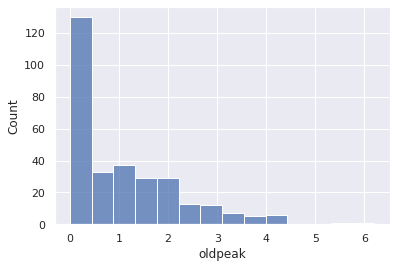

In [23]:
sns.histplot(x='oldpeak', data=df)

# Imensa maioria do dataset possui valores baixos.


###3.10.2. Boxplot

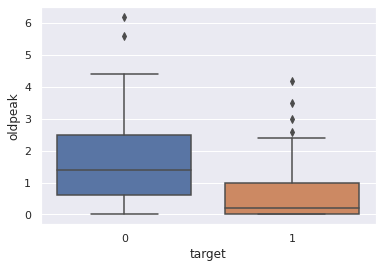

In [24]:
sns.boxplot(x='target', y='oldpeak', data=df)

# Presença de outliers nos dois casos.
# Casos negativos aparentem ter oldpeak maior.


###3.10.3. Frequência

In [25]:
df['oldpeak'].value_counts()

# 33% do dataset possui valor 0.

0.000    99
1.200    17
0.600    14
1.000    14
0.800    13
         ..
0.700     1
5.600     1
3.800     1
2.900     1
3.500     1
Name: oldpeak, Length: 40, dtype: int64

##3.11. Coluna slope
Tipo de inclinação do segmento ST de pico do exercício

In [26]:
df['slope'].value_counts()

# 6,7% do dataset possui valor 0, o restante divide-se entre 1 ou 2.


2    142
1    140
0     21
Name: slope, dtype: int64

##3.12. Coluna ca
Número de vasos sanguínios ressaltados (coloridos por fluoroscopia)

In [27]:
df['ca'].value_counts()

# Mais de 50% do banco de dados não possui nenhum vaso sanguíneo ressaltado


0    175
1     65
2     38
3     20
4      5
Name: ca, dtype: int64

##3.13. Coluna Thal
Talassemia -> 3 = normal; 6 = fixed defect; 7 = reversable defect

In [28]:
df['thal'].value_counts()

# Dados não condizem com a legenda: dados variam de 0 a 3 e a legenda refere-se a 3, 6 ou 7.
# Provavelmente os valores 0 são dados sujos, 1=Normal; 2=Fixed defect; 3=Reversable defect

2    166
3    117
1     18
0      2
Name: thal, dtype: int64

###3.13.1 Removendo os valores 0

In [29]:
df= df[df['thal'] != 0]
df['thal'].value_counts()

2    166
3    117
1     18
Name: thal, dtype: int64

###3.13.2. Transformando a variável em categórica

In [30]:
df['thal']=df['thal'].apply(lambda x: "Normal" if x==1 else ("Fixed defect" if x==2 else "Reversable defect"))
df['thal'].value_counts()

Fixed defect         166
Reversable defect    117
Normal                18
Name: thal, dtype: int64

In [31]:
df['thal']=df['thal'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       301 non-null    int64   
 1   sex       301 non-null    int64   
 2   cp        301 non-null    int64   
 3   trestbps  301 non-null    int64   
 4   chol      301 non-null    int64   
 5   fbs       301 non-null    int64   
 6   restecg   301 non-null    int64   
 7   thalach   301 non-null    int64   
 8   exang     301 non-null    int64   
 9   oldpeak   301 non-null    float64 
 10  slope     301 non-null    int64   
 11  ca        301 non-null    int64   
 12  thal      301 non-null    category
 13  target    301 non-null    int64   
dtypes: category(1), float64(1), int64(12)
memory usage: 33.3 KB


## 3.14. Variável TARGET

In [32]:
df['target'].value_counts()

# O número de casos positivos é próximo do número de casos negativos. Diminui a chance de vies do modelo.


1    164
0    137
Name: target, dtype: int64

# 3.15. Correlações

In [33]:
df.corr()

# A variável target possui correção forte com cp, thalach, exang, oldpeak, ca e thal.

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,target
age,1.000,-0.099,-0.069,0.279,0.213,0.124,-0.116,-0.401,0.098,0.210,-0.169,0.276,-0.227
sex,-0.099,1.000,-0.043,-0.058,-0.200,0.038,-0.066,-0.052,0.136,0.092,-0.025,0.117,-0.276
cp,-0.069,-0.043,1.000,0.048,-0.078,0.105,0.051,0.304,-0.390,-0.147,0.115,-0.182,0.430
trestbps,0.279,-0.058,0.048,1.000,0.122,0.181,-0.115,-0.048,0.068,0.193,-0.122,0.101,-0.146
chol,0.213,-0.200,-0.078,0.122,1.000,0.019,-0.151,-0.012,0.070,0.052,-0.004,0.067,-0.087
...,...,...,...,...,...,...,...,...,...,...,...,...,...
exang,0.098,0.136,-0.390,0.068,0.070,0.014,-0.078,-0.387,1.000,0.288,-0.254,0.118,-0.433
oldpeak,0.210,0.092,-0.147,0.193,0.052,0.005,-0.062,-0.350,0.288,1.000,-0.577,0.221,-0.430
slope,-0.169,-0.025,0.115,-0.122,-0.004,-0.054,0.099,0.395,-0.254,-0.577,1.000,-0.080,0.343
ca,0.276,0.117,-0.182,0.101,0.067,0.144,-0.073,-0.217,0.118,0.221,-0.080,1.000,-0.394


##3.16 CONCLUSÕES

In [34]:
target = ['target']
Variaveis_categoricas = ['thal', 'slope']
Variaveis_discretas = ['cp', 'ca','oldpeak', 'resteg']
Variaveis_booleanas = ['sex', 'fbs', 'exang']
Variaveis_continuas = ['age','trestbps','chol','thalach']
features = Variaveis_categoricas + Variaveis_discretas + Variaveis_booleanas + Variaveis_continuas

#4. Transformações e Modelagem

##4.1. Classificando as features

In [35]:
df[Variaveis_categoricas]=df[Variaveis_categoricas].astype('category')
#df[Variaveis_booleanas]=df[Variaveis_booleanas].astype('boolean')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       301 non-null    int64   
 1   sex       301 non-null    int64   
 2   cp        301 non-null    int64   
 3   trestbps  301 non-null    int64   
 4   chol      301 non-null    int64   
 5   fbs       301 non-null    int64   
 6   restecg   301 non-null    int64   
 7   thalach   301 non-null    int64   
 8   exang     301 non-null    int64   
 9   oldpeak   301 non-null    float64 
 10  slope     301 non-null    category
 11  ca        301 non-null    int64   
 12  thal      301 non-null    category
 13  target    301 non-null    int64   
dtypes: category(2), float64(1), int64(11)
memory usage: 31.4 KB


##4.2. Normalizando as variáveis contínuas

In [36]:
scaler = StandardScaler()
scaler.fit(df[Variaveis_continuas])
df_Test=scaler.transform(df[Variaveis_continuas])

In [37]:
df_Test = pd.DataFrame(data=df_Test)
df_Test.head()

,0,1,2,3
0,0.948,0.760,-0.261,0.011
1,-1.911,-0.094,0.067,1.630
2,-1.471,-0.094,-0.820,0.974
3,0.178,-0.663,-0.203,1.237
4,0.288,-0.663,2.074,0.580


In [38]:
df_Test = df_Test.rename(columns={0:'age', 1:'trestbps', 2:'chol', 3:'thalach'})
df_Test.head()

,age,trestbps,chol,thalach
0,0.948,0.760,-0.261,0.011
1,-1.911,-0.094,0.067,1.630
2,-1.471,-0.094,-0.820,0.974
3,0.178,-0.663,-0.203,1.237
4,0.288,-0.663,2.074,0.580


In [39]:
df=df.drop(columns=Variaveis_continuas)

In [40]:
df=pd.concat([df, df_Test], axis=1)
df.head()

,sex,cp,fbs,restecg,exang,oldpeak,slope,ca,thal,target,age,trestbps,chol,thalach
0,1.000,3.000,1.000,0.000,0.000,2.300,0,0.000,Normal,1.000,0.948,0.760,-0.261,0.011
1,1.000,2.000,0.000,1.000,0.000,3.500,0,0.000,Fixed defect,1.000,-1.911,-0.094,0.067,1.630
2,0.000,1.000,0.000,0.000,0.000,1.400,2,0.000,Fixed defect,1.000,-1.471,-0.094,-0.820,0.974
3,1.000,1.000,0.000,1.000,0.000,0.800,2,0.000,Fixed defect,1.000,0.178,-0.663,-0.203,1.237
4,0.000,0.000,0.000,1.000,1.000,0.600,2,0.000,Fixed defect,1.000,0.288,-0.663,2.074,0.580


In [47]:
df = pd.get_dummies(df)
df.head()

,sex,cp,fbs,restecg,exang,oldpeak,ca,target,age,trestbps,chol,thalach,slope_0,slope_1,slope_2,thal_Fixed defect,thal_Normal,thal_Reversable defect
0,1.000,3.000,1.000,0.000,0.000,2.300,0.000,1.000,0.948,0.760,-0.261,0.011,1,0,0,0,1,0
1,1.000,2.000,0.000,1.000,0.000,3.500,0.000,1.000,-1.911,-0.094,0.067,1.630,1,0,0,1,0,0
2,0.000,1.000,0.000,0.000,0.000,1.400,0.000,1.000,-1.471,-0.094,-0.820,0.974,0,0,1,1,0,0
3,1.000,1.000,0.000,1.000,0.000,0.800,0.000,1.000,0.178,-0.663,-0.203,1.237,0,0,1,1,0,0
4,0.000,0.000,0.000,1.000,1.000,0.600,0.000,1.000,0.288,-0.663,2.074,0.580,0,0,1,1,0,0


In [55]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 300
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sex                     299 non-null    float64
 1   cp                      299 non-null    float64
 2   fbs                     299 non-null    float64
 3   restecg                 299 non-null    float64
 4   exang                   299 non-null    float64
 5   oldpeak                 299 non-null    float64
 6   ca                      299 non-null    float64
 7   target                  299 non-null    float64
 8   age                     299 non-null    float64
 9   trestbps                299 non-null    float64
 10  chol                    299 non-null    float64
 11  thalach                 299 non-null    float64
 12  slope_0                 299 non-null    uint8  
 13  slope_1                 299 non-null    uint8  
 14  slope_2                 299 non-null    ui

In [56]:
df_Clean = df.copy()

#5. Testando modelos
Devido ao tipo do problema, escolheu-se utilizar um modelo de calssificação não supervisionado visto que o tamanho do dataset é pequeno (300 linhas) e que o target é "Possui doença coranária" ou "Não possui doença coranária"

In [57]:
# Dividindo entre features e target
y = df['target']
X = df.drop(columns={'target'})
print(X.shape, y.shape)

(299, 17) (299,)


In [58]:
y.dtypes

dtype('float64')

In [59]:
np.isnan(y).any()

False

##5.2. RandomForestClassifier

In [63]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
y_pred = clf.predict(X)

In [64]:
from sklearn.metrics import f1_score
print(f1_score(y, y_pred))

0.8823529411764706


##5.3. AgglomerativeClustering

In [69]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2)  
labels = cluster.fit_predict(X, y)
y_pred=labels.astype('int64') # aqui atribuimos o numero de cada clusters

In [70]:
print(f1_score(y, y_pred)) # Acurácia baixa pois pontos próximos do dataset possuem classificações diferentes

0.7866666666666666


#6. Otimizando modelo por RandomForestClassifier

In [77]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100, 300, 500]
max_depth = [5, 25, 30]
min_samples_split = [2, 15, 100]
min_samples_leaf = [1, 10] 
forest = RandomForestClassifier(random_state = 1)
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)

In [78]:
bestF = gridF.fit(X, y)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  1.0min finished


In [79]:
y_pred = bestF.predict(X)
print(f1_score(y, y_pred))

1.0
